In [ ]:
import json
import torch
import ultraprint.common as p
import os
import random
import numpy as np
from tqdm import tqdm
from torch import nn

In [2]:
data_dir = 'kaggle_data'
model_dir = 'models/ranit/genre'
model_name = model_dir+'/ranit_genre_classifier_v1'

#create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

In [3]:

#make the file only if the file does not exist
if not os.path.exists(f'{model_dir}/classes.json'):
    
    p.yellow('classes.json not found, creating a new one')
    #get all folder name in the folder
    def get_all_folder_name(folder):
        return [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]

    classes = get_all_folder_name(data_dir)

    # store the class names in a json file in model_dir
    with open(f'{model_dir}/classes.json', 'w') as f:
        json.dump(classes, f)
else:

    p.green('classes.json found, loading it')
    with open(f'{model_dir}/classes.json', 'r') as f:
        classes = json.load(f)

classes, len(classes)

 classes.json found, loading it


(['blues',
  'classical',
  'country',
  'disco',
  'hiphop',
  'jazz',
  'metal',
  'pop',
  'reggae',
  'rock'],
 10)

In [4]:
def get_batch(n=5):
    #get random files from withing each folder and for each also store the array containing the expected output
    x = []
    y = []
    for i in range(n):
        c = random.choice(classes)
        files = os.listdir(os.path.join(data_dir, c))
        f = random.choice(files)
        x.append(os.path.join(data_dir, c, f))
        # y should be a one hot encoded vector
        one_hot = [0] * len(classes)
        one_hot[classes.index(c)] = 1
        y.append(one_hot)
    
    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)
    return x, y_tensor

get_batch(5)

(['kaggle_data\\classical\\classical.00073.wav',
  'kaggle_data\\rock\\rock.00033.wav',
  'kaggle_data\\metal\\metal.00046.wav',
  'kaggle_data\\country\\country.00001.wav',
  'kaggle_data\\blues\\blues.00027.wav'],
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'))

In [ ]:
from audio_model import GenureClassifier

def train(epochs=100, batch_size=5, learning_rate=0.00001):
    
    # Initialize model and optimizer
    # Model outputs 10 classes
    model = GenureClassifier(device=device)
    model.load(model_name)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        epoch_losses = []
         
        # Create progress bar for each epoch
        with tqdm(range(100), desc=f'Epoch {epoch+1}/{epochs}') as pbar:
            for _ in pbar:

                try:
                    # Get batch
                    audio_paths, labels = get_batch(batch_size)

                    # continue if batch size is less than expected
                    if len(audio_paths) != batch_size:
                        p.yellow(f'Batch size mismatch, skipping batch')
                        continue

                    # Forward pass
                    probabilities = model(audio_paths)

                    # check if length of probabilities is equal to length of labels
                    if len(probabilities) != len(labels):
                        p.yellow(f'Length mismatch between probabilities and labels, skipping batch')
                        continue

                    # Check gradient
                    if not probabilities.requires_grad:
                        p.yellow("Warning: probabilities lost gradient tracking")
                        continue

                    # Calculate loss
                    loss = criterion(probabilities, labels)
                    
                    if not loss.requires_grad:
                        p.yellow("Warning: loss lost gradient tracking")
                        continue

                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # Track progress
                    epoch_losses.append(loss.item())

                    pbar.set_postfix({'loss': np.mean(epoch_losses)})

                except Exception as e:
                    #print full stack trace
                    p.red(e)
                    continue
        
        # Save model checkpoint every epochs
        model.save(model_name)
        p.green(f'\nCheckpoint saved at epoch {epoch+1}')
            
        p.blue(f'Epoch {epoch+1} average loss: {np.mean(epoch_losses):.4f}')

# Start training
if __name__ == "__main__":
    train(batch_size=100)

Audio paths: ['kaggle_data\\metal\\metal.00085.wav']
Labels shape: torch.Size([1, 10])
Probabilities shape: torch.Size([1, 10])

Predictions:
Prediction 1: metal (Probability: 0.9986)

Ground truth:
Prediction 1: metal (Probability: 1.0000)


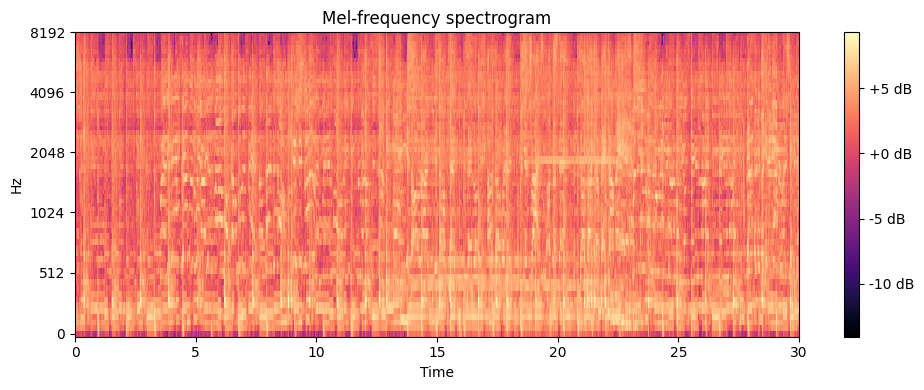

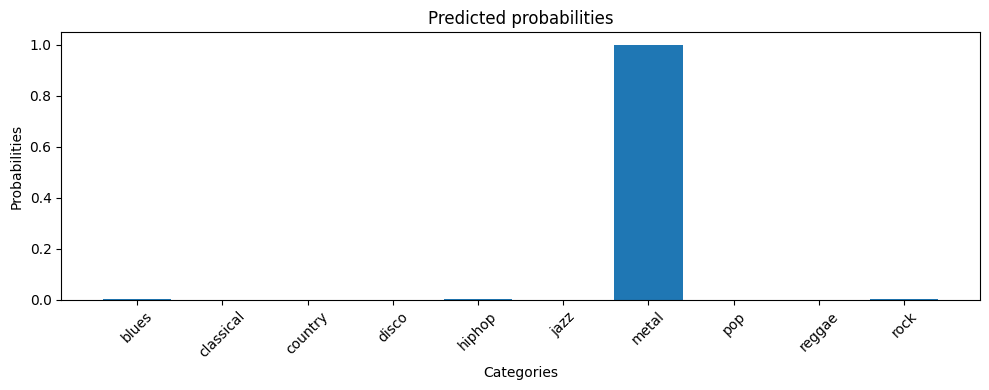

In [16]:
import torch
import torch.nn.functional as F
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from model_utils import extract_features
import torchaudio.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = T.MelSpectrogram(
    sample_rate=16000, 
    n_fft=1024, 
    hop_length=512, 
    n_mels=64
).to(device)

def load_model(model_class, model_path, device='cuda'):
    model = model_class(device=device)
    model.load(model_path)
    model.eval()
    return model

def get_classes(model_dir):
    try:
        with open(f'{model_dir}/classes.json', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        raise ValueError(f"Class file not found at {model_dir}/classes.json")

def display_predictions(probabilities, classes):
    predicted_classes = torch.argmax(probabilities, dim=1)
    for i, class_idx in enumerate(predicted_classes):
        class_name = classes[class_idx.item()]
        probability = probabilities[i, class_idx].item()
        print(f"Prediction {i + 1}: {class_name} (Probability: {probability:.4f})")

def plot_mel_spectrogram(audio_path):
    features_batch = extract_features([audio_path], transform, device)
    if features_batch is not None:
        S_dB = features_batch.squeeze().cpu().numpy()
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_dB, sr=16000, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.tight_layout()
        plt.show()

def plot_probabilities(probabilities, category_names, title):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(probabilities)), probabilities, tick_label=category_names)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":

    try:
        # Load model
        model = load_model(GenureClassifier, model_name)

        # Get batch (assuming get_batch is implemented elsewhere)
        audio_paths, labels = get_batch(n=1)
        print("Audio paths:", audio_paths)
        print("Labels shape:", labels.shape)

        with torch.no_grad():
            logits = model(audio_paths)
            probabilities = F.softmax(logits, dim=1)

        print("Probabilities shape:", probabilities.shape)

        # Load class names
        classes = get_classes(model_dir)

        # Display predictions
        print("\nPredictions:")
        display_predictions(probabilities, classes)

        # Display ground truth (assuming labels are in the same format as probabilities)
        print("\nGround truth:")
        display_predictions(labels, classes)

        # Visualize audio
        audio_path = audio_paths[0]
        plot_mel_spectrogram(audio_path)

        # Plot probabilities
        probabilities_np = probabilities.cpu().numpy().squeeze()
        plot_probabilities(probabilities_np, classes, 'Predicted probabilities')

    except Exception as e:
        print(f"An error occurred: {e}")


In [10]:
# Test2
test_audio_path = ['cache/classical.mp3']

model = load_model(GenureClassifier, model_name)

with torch.no_grad():
    logits = model(test_audio_path)
    probabilities = F.softmax(logits, dim=1)

# Load class names
classes = get_classes(model_dir)

# Display predictions
print("\nPredictions:")
display_predictions(probabilities, classes)

for i in range(len(classes)):
    print(classes[i], end=': ')
    print(round(probabilities[0][i].item(), 4))


Predictions:
Prediction 1: classical (Probability: 0.4847)
blues: 0.0841
classical: 0.4847
country: 0.0448
disco: 0.0011
hiphop: 0.0002
jazz: 0.3199
metal: 0.0004
pop: 0.0051
reggae: 0.0535
rock: 0.0061
